Justin Baseline CNN Notebook
10/30/2020

In [1]:
%matplotlib inline

#Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Modeling imports
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Metrics
from sklearn.metrics import mean_squared_error, r2_score

#NN Imports
from keras import optimizers
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K

np.random.seed(0)
print ("OK")

OK


In [2]:
train_data = pd.read_csv("training.csv")  
test_data = pd.read_csv("test.csv")
lookid_data = pd.read_csv("IdLookupTable.csv")

print(train_data.shape)
print(test_data.shape)

(7049, 31)
(1783, 2)


TODO: Figure out how to treat incomplete examples. Build a function that allows us to easily toggle which proportion of the training data is used.

In [3]:
train_data.head()
train_data.isnull().any().value_counts() #3 Missing Values, will need to fill in somehow

train_data.fillna(method = 'ffill',inplace = True) #Fill missing with previous data

First, separating training and test features from labels.

In [4]:
#Functions to separate features and labels

def get_features(df, dim=2):
    #Input train or test dataframe and number of dimensions you want features in.
    #Returns vector of features (pixel intensities for all examples)
    #TODO: divided by 255 for scaling?
    
    images_list = []

    for i in range(0, df.shape[0]):
        image = df["Image"][i].split(' ')
        image = ["0" if x == '' else x for x in image]
        images_list.append(image)
    
    images_array = np.array(images_list, dtype="float")
    if dim==2:
        images_features = images_array.reshape(-1, 96, 96, 1)
    else:
        images_features = images_array

    return images_features

def get_labels(df):
    #Input only test dataframe
    #Returns vector of labels (num_examples by 30 column vector of X,Y coords for face keypoints)
    
    #Grabbing the corresponding training labels
    labels_df = df.drop("Image", axis = 1)
    image_labels = []

    for i in range(0, df.shape[0]):
        keypoint_coords = labels_df.iloc[i, :]
        image_labels.append(keypoint_coords)
    
    return np.array(image_labels, dtype = "float")

X = get_features(train_data, dim=2) #Returns 96x96x1 for CNN model
y = get_labels(train_data)
X_test = get_features(test_data, dim=2)
#No Y_test provided as this is hidden by kaggle?

print(f"Training features shape: {X.shape}")
print(f"Training labels shape: {y.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (7049, 96, 96, 1)
Training labels shape: (7049, 30)
Test features shape: (1783, 96, 96, 1)


Splitting our training set into train and dev for tuning. TODO: try k-fold cross validation instead of 80/20 split.

In [5]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train examples: {X_train.shape[0]}")
print(f"Train labels: {y_train.shape[0]}")
print(f"Dev examples: {X_dev.shape[0]}")
print(f"Dev labels {y_dev.shape[0]}")

Train examples: 5639
Train labels: 5639
Dev examples: 1410
Dev labels 1410


EDA. Function to plot different numbers of examples and color type. TODO: plot x marks for the labels on the images themselves!

Someone did this here: https://www.kaggle.com/balraj98/data-augmentation-for-facial-keypoint-detection

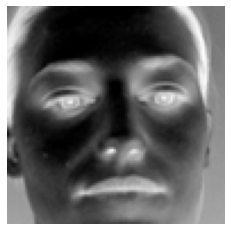

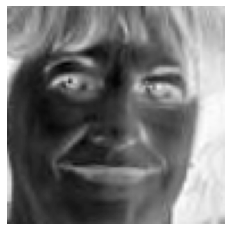

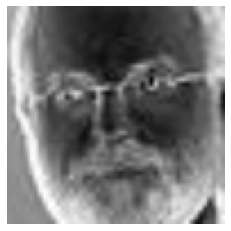

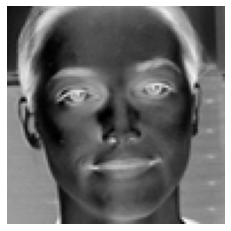

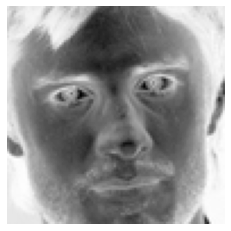

In [6]:
def show_example_images(feature_data=X_train, num_examples=20, color="binary"):
    #Specify feature vector (probably training features), number of examples, and cmap choice 
    
    plt.rc('image', cmap='gray') #Setting colormap to black and white

    for example in range(num_examples):
        digit_image = feature_data[example].reshape((96, 96)) #1D to 2D matrix conversion for example digits
        plt.imshow(digit_image, cmap=color)
        plt.axis("off")
        plt.show()
        
show_example_images(num_examples=5, color="binary")

TODO Feature Engineering Goes Here

#Functions for transforming features before model fitting.

1) "One suggestion, I think you can normalize the target(y or Coordinates of Landmarks) as well.
As the images length and breadth cannot exceed 96 pixels, so the landmark coordinates cannot exceed 96 either. If you divide the total target (y) array by 96 then those values will range between 0 to 1.
As a result the model will be less likely to overfit and you will be able to gain much accuracy!"

2) PCA on the image pixels similar to eigen_faces

**Baseline Models**

We first fit a baseline Convolution Neural Network (CNN) that trains on 80% of the face examples. The examples are read in as unscaled 96x96 2d pixel intensities. The basic CNN has two convolutional layers with 32 and 64 features, respectively, and a max pooling layer. The feed-forward part of the network has a hidden layer of 50 nodes and the final output layer outputs 30 continuous-valued coordinate predictions.

In [7]:
# Setting example image dimensions
img_rows = 96
img_cols = 96

# ===Begin Specifying Baseline CNN Architecture===
cnn_model = Sequential()

# 32 Convolution filters used
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(img_rows, img_cols, 1)))

# 64 Convolution filters used, each of size 3x3
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))

# Choose best features using max pooling layer 
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) #2d can be used for 2 dimensional input. No depth here.

# Optional dropout layer. No need for baseline model.
# cnn_model.add(Dropout(0.2)) #20% of the nodes are not going to activate at each layer of the network.

# Flatten convolution features to pass through into the feed forward network. So 2d layer to 1d layer.
cnn_model.add(Flatten())

cnn_model.add(Dense(units=512, input_dim=128, activation='relu'))
#50 node network. Must be smaller than previous layer.
#Input dimensions is 128 because 

#During gradient descent, you're refining 50 nod
cnn_model.add(Dense(units=30, input_dim=50, activation='softmax'))  #10 node network

#Summarize Model
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               69337600  
_________________________________________________________________
dense_1 (Dense)              (None, 30)                15390     
Total params: 69,371,806
Trainable params: 69,371,806
Non-trainable params: 0
____________________________________________


Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:
Loss function - measures how accurate the model is during training, we want to minimize this with the optimizer.
Optimizer - how the model is updated based on the data it sees and its loss function.
Metrics - used to monitor the training and testing steps. "accuracy" is the fraction of images that are correctly classified.

In [8]:
## Cost function & Objective (and solver)
cnn_model.compile(optimizer="adam", loss='mean_squared_error', metrics=['accuracy']) #put in MAE

history = cnn_model.fit(X_train, y_train, epochs=10)
# score = cnn_model.evaluate(X_dev, y_dev, verbose=0)

# print('Test score:', score[0])  #The model is trying to minimize the loss here.
# print('Test accuracy:', score[1])

Epoch 1/10
177/177 [==============================] - 84s 476ms/step - loss: 2673.6206 - accuracy: 0.6168
Epoch 2/10
177/177 [==============================] - 82s 461ms/step - loss: 2673.6101 - accuracy: 0.6196
Epoch 3/10
177/177 [==============================] - 78s 439ms/step - loss: 2673.6101 - accuracy: 0.6196
Epoch 4/10
177/177 [==============================] - 79s 444ms/step - loss: 2673.6089 - accuracy: 0.6196
Epoch 5/10
177/177 [==============================] - 79s 444ms/step - loss: 2673.6082 - accuracy: 0.6196
Epoch 6/10
177/177 [==============================] - 75s 423ms/step - loss: 2673.6089 - accuracy: 0.6196
Epoch 7/10
177/177 [==============================] - 72s 409ms/step - loss: 2673.6094 - accuracy: 0.6196
Epoch 8/10
177/177 [==============================] - 72s 408ms/step - loss: 2673.6079 - accuracy: 0.6196
Epoch 9/10
177/177 [==============================] - 72s 409ms/step - loss: 2673.6094 - accuracy: 0.6196
Epoch 10/10
177/177 [=========================

**The model doesn't seem to be converging. Will have to spend more time on the baseline CNN.**

In [ ]:
#Below only works if you use 1d image inputs
# rf = RandomForestRegressor(max_depth=4, random_state=42, n_jobs=-1)
# rf.fit(X_train, y_train)
# print("RF done training")
# rf_y_dev_pred = rf.predict(X_dev)

In [ ]:
# print('Random Forest Regression Dev Root Mean squared error: %.2f'
#       % mean_squared_error(y_dev, rf_y_dev_pred, squared=False))

# print('Random Forest Regression Dev R-square: %.2f'
#       % r2_score(y_dev, rf_y_dev_pred))

TODO:

1) Function that plots the test keypoints on the test images. 

2) Outputting Predictions for Kaggle Submission and Scoring.

In [ ]:
#Script for outputting Kaggle submission (.csv format)